In [1]:
import sys
sys.path.append('/Users/koush/Projects/Banksy_py')
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from banksy_utils.load_data import load_adata, display_adata

In [203]:
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(points, alpha, only_outer=True):
    assert points.shape[0] > 3, "Need at least four points"
    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))
    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))

        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    
    return edges

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3540
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

In [46]:
raw_x, raw_y = adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1]

In [47]:
# display_adata(adata)

In [48]:
from banksy.main import median_dist_to_nearest_neighbour

In [49]:
plot_graph_weights = True
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(adata, key = 'spatial')


Median distance to closest cell = 13.162909136636577

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----



In [50]:
adata.obs['x'] = raw_x
adata.obs['y'] = raw_y


Median distance to closest cell = 13.162909136636577

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.03 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.09 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 44.51081302877048, mode = 45.529551911354226

---- Ran plot_edge_histogram in 0.23 s ----


Edge weights (weights between cells): median = 0.05772687203986537, mode = 0.041943398344353615

---- Ran plot_edge_histogram in 0.02 s ----

---- Ran generate_spatial_distance_graph in 0.03 s ----

---- Ran theta_from_spatial_graph in 0.03 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.12 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 63.39150538356155, mode = 69.48229249993267

---- Ran plot_edge_histogram in 0.02 s ----


Edge

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7004: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16
/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


---- Ran plot_graph_weights in 0.38 s ----

Maximum weight: (0.09135479832004889+0.0142108386170042j)

---- Ran plot_graph_weights in 0.90 s ----

----- Plotting theta Graph -----


/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/matplotlib/collections.py:426: ComplexWarning: Casting complex values to real discards the imaginary part
  renderer.draw_path_collection(


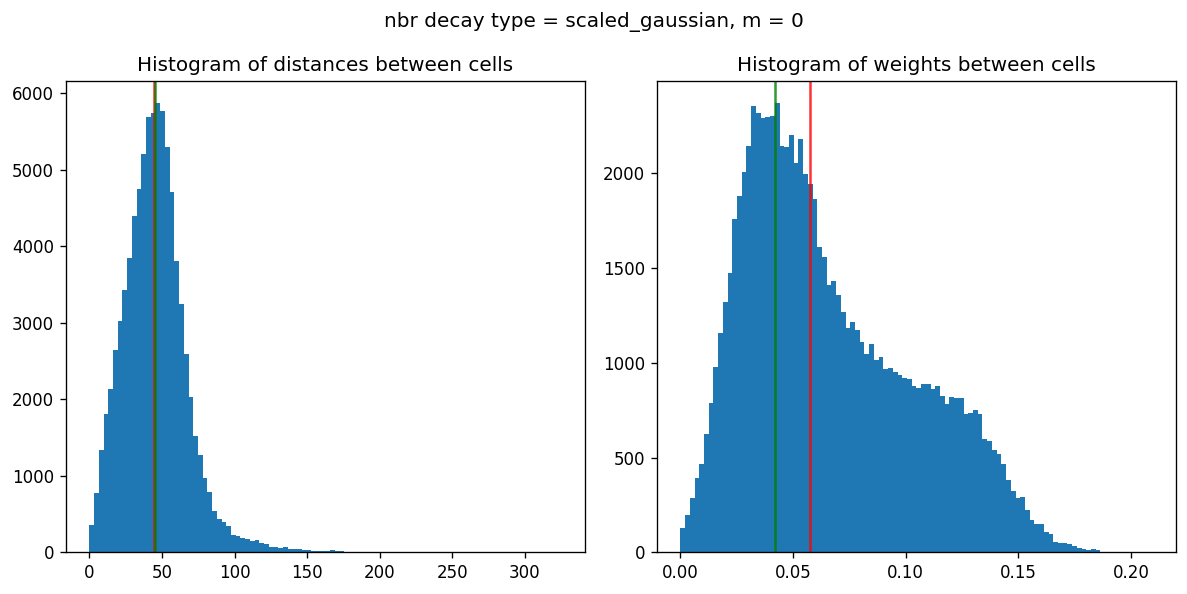

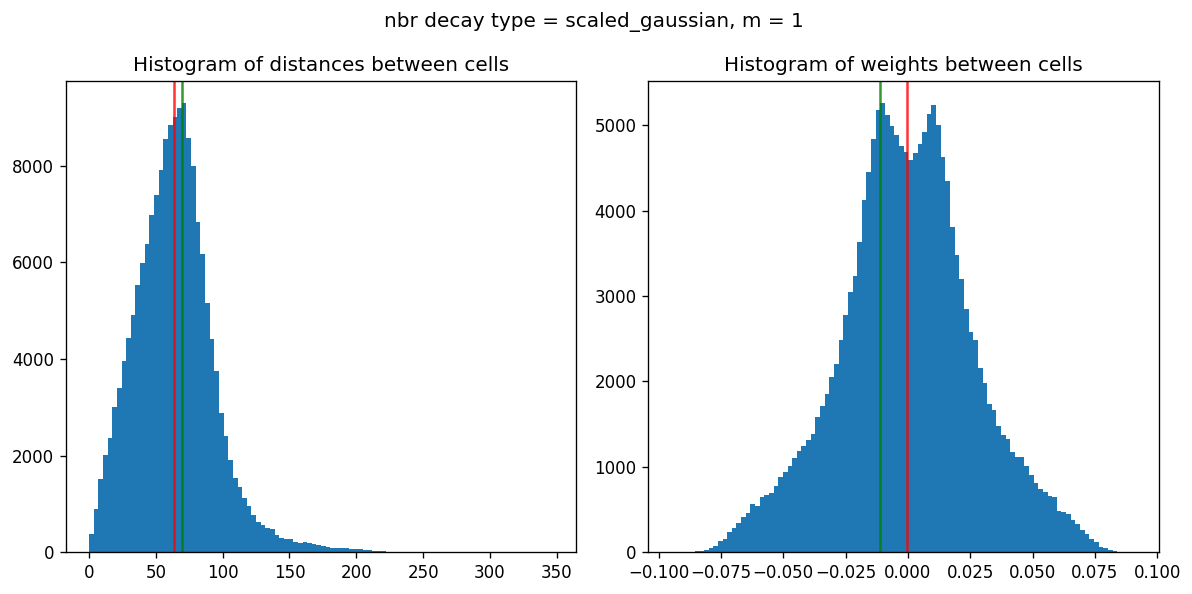

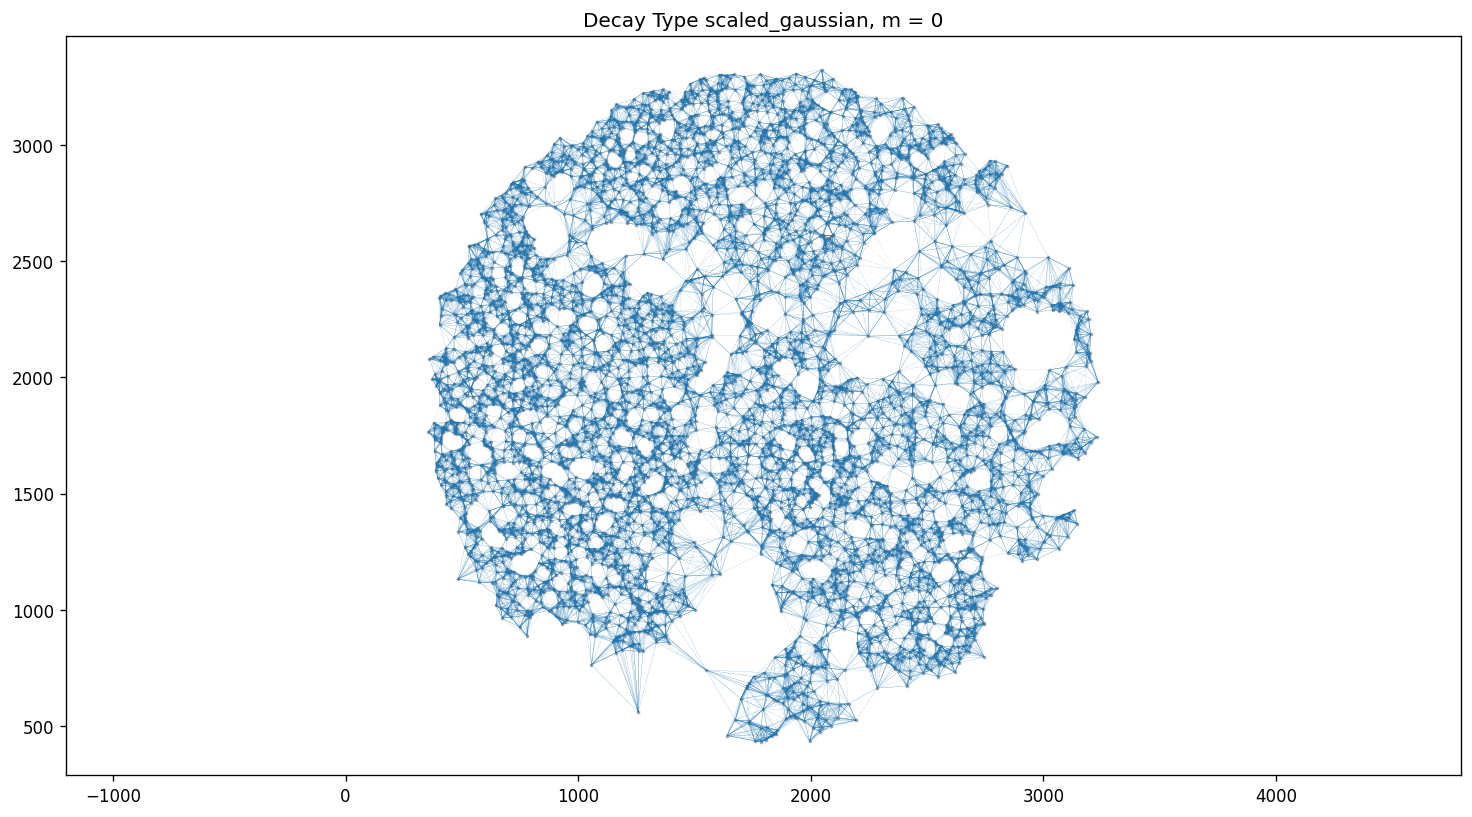

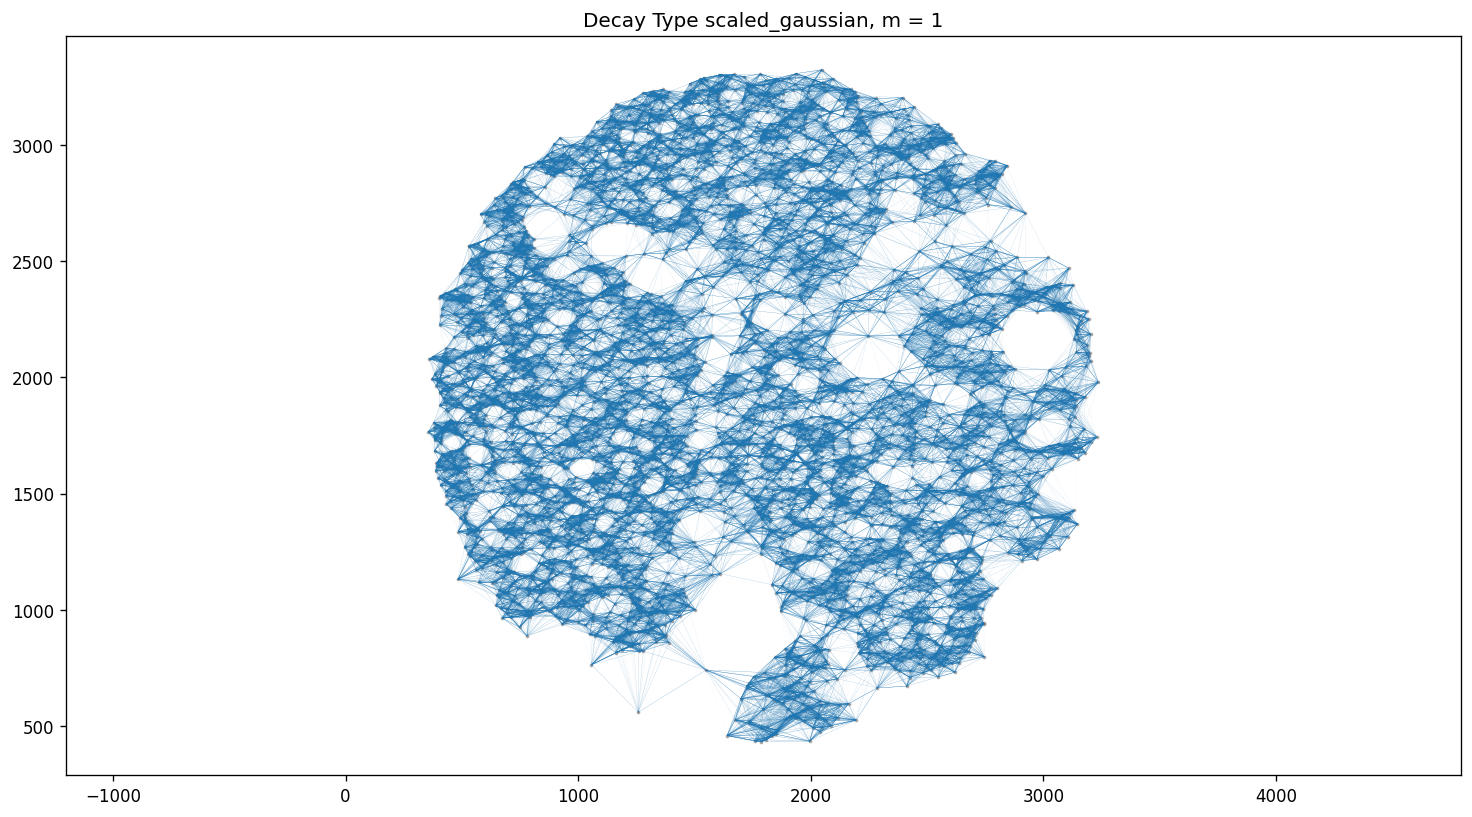

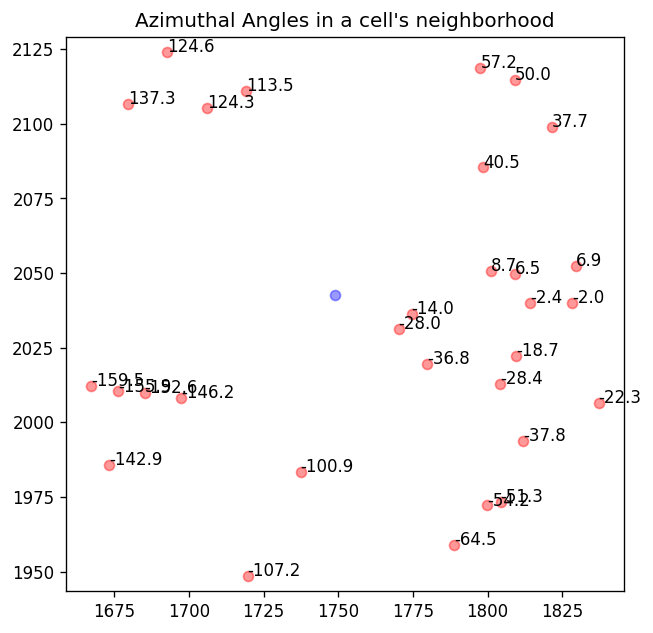

In [51]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [71]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [1.5]  # clustering resolution for UMAP
pca_dims = [50]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
banksy_matrix

Runtime Jan-26-2025-20-10

3540 genes to be analysed:
Gene List:
Index(['LINC01128', 'TNFRSF18', 'TNFRSF4', 'INTS11', 'MRPL20-AS1', 'SKI',
       'PEX10', 'PLCH2', 'PRXL2B', 'TTC34',
       ...
       'F8', 'F8A1', 'CLIC2', 'TMLHE-AS1', 'ZFY-AS1', 'LINC00278', 'PCDH11Y',
       'NLGN4Y', 'TTTY14', 'TTTY10'],
      dtype='object', name='Unnamed: 0', length=3540)

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <5778x5778 sparse matrix of type '<class 'numpy.float64'>'
	with 86670 stored elements in Compressed Sparse Row format>, 1: <5778x5778 sparse matrix of type '<class 'numpy.complex128'>'
	with 173340 stored elements in Compressed Sparse Row format>}, 'norm_counts_concatenated': array([[0.        , 0.        , 0.        , ..., 0.09719611, 0.05134671,
        0.15568715],
       [0.        , 0.        , 0.        , ..., 0.02099579, 0.11508084,
        0.06329367],
       [0.88378866, 0.        , 0.        , ..., 0.13055805, 0.0712133 ,
        0.03049477],
       ...,
   

AnnData object with n_obs × n_vars = 5778 × 10620
    obs: 'cell_type', 'cell_type_int', 'x', 'y', 'banksy_cluster'
    var: 'is_nbr', 'k'

In [53]:
# from banksy.main import concatenate_all

# banksy_dict["nonspatial"] = {
#     # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
#     0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
# }

# print(banksy_dict['nonspatial'][0.0]['adata'])

In [72]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

Current decay types: ['scaled_gaussian']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 50
Original shape of matrix: (5778, 10620)
Reduced shape of matrix: (5778, 50)
------------------------------------------------------------
min_value = -40.418532311604885, mean = -7.019345683140623e-17, max = 74.75809157918066

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_50_umap"]
UMAP embedding
------------------------------------------------------------
shape: (5778, 2)


AxisArrays with keys: reduced_pc_50, reduced_pc_50_umap


In [73]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50, # k_expr: number of neighbours in expression (BANKSY embedding or non-spatial) space
    num_iterations = -1, # run to convergenece
    partition_seed = 42,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.2
reduced_pc_50 

reduced_pc_50_umap 

PCA dims to analyse: [50]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.2, PCA dimensions = 50)


Nearest-neighbour weighted graph (dtype: float64, shape: (5778, 5778)) has 288900 nonzero entries.
---- Ran find_nn in 0.78 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (5778, 5778)) has 288900 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 3871828 to 288256.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (5778, 5778)) has 278472 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (5778, 5778)) has 278472 nonzero entries.

sNN graph data:
[21 16 14 ... 16 14 20]

---- Ran shared_nn in 0.13 s ----


-- Multiplying sNN connectivity by weights --


shared NN w

/Users/koush/Projects/Banksy_py/banksy/labels.py:398: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expand_labels(label_list[sort_indices[0]],


decay  lambda_param  num_pcs  \
scaled_gaussian_pc50_nc0.20_r1.50  scaled_gaussian           0.2       50   

                                   resolution  num_labels  \
scaled_gaussian_pc50_nc0.20_r1.50         1.5          15   

                                                                              labels  \
scaled_gaussian_pc50_nc0.20_r1.50  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc50_nc0.20_r1.50  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc50_nc0.20_r1.50  Label object:\nNumber of labels: 15, number of...

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((15, 5778) x (5778, 5778) x (5778, 15))



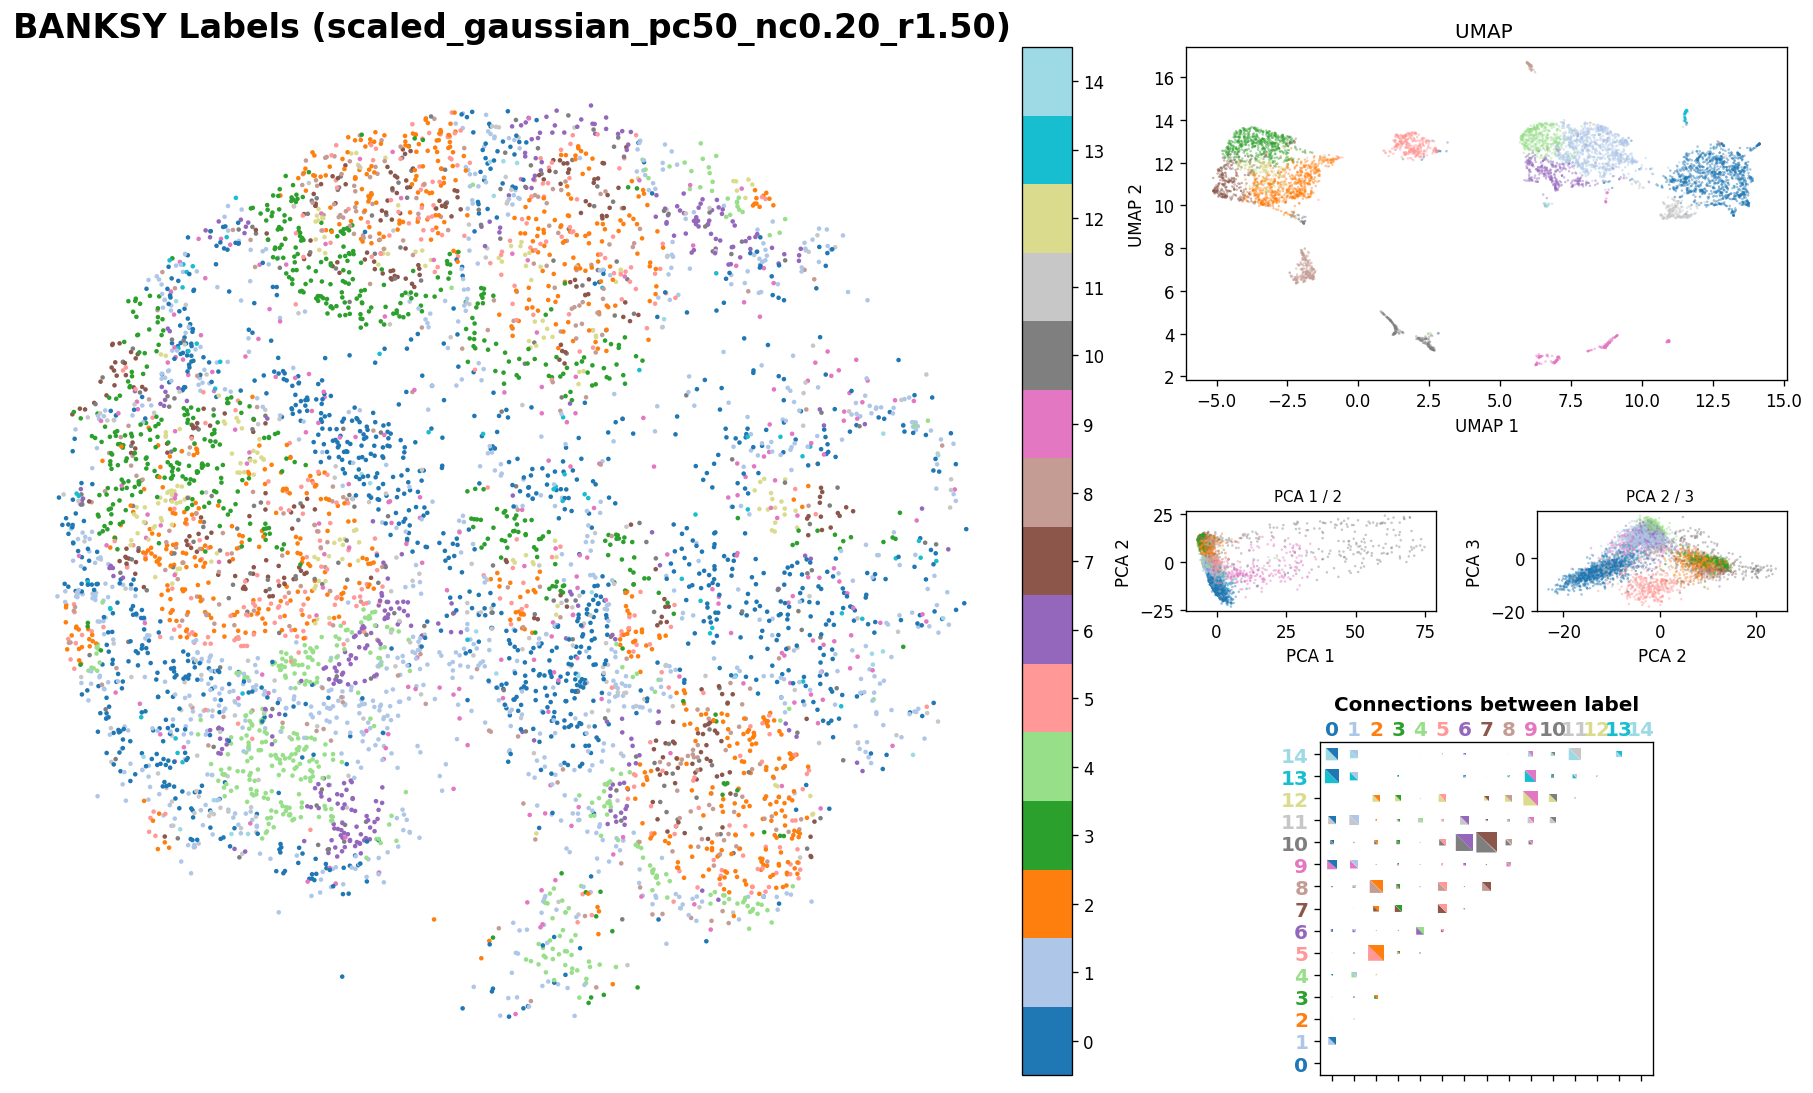

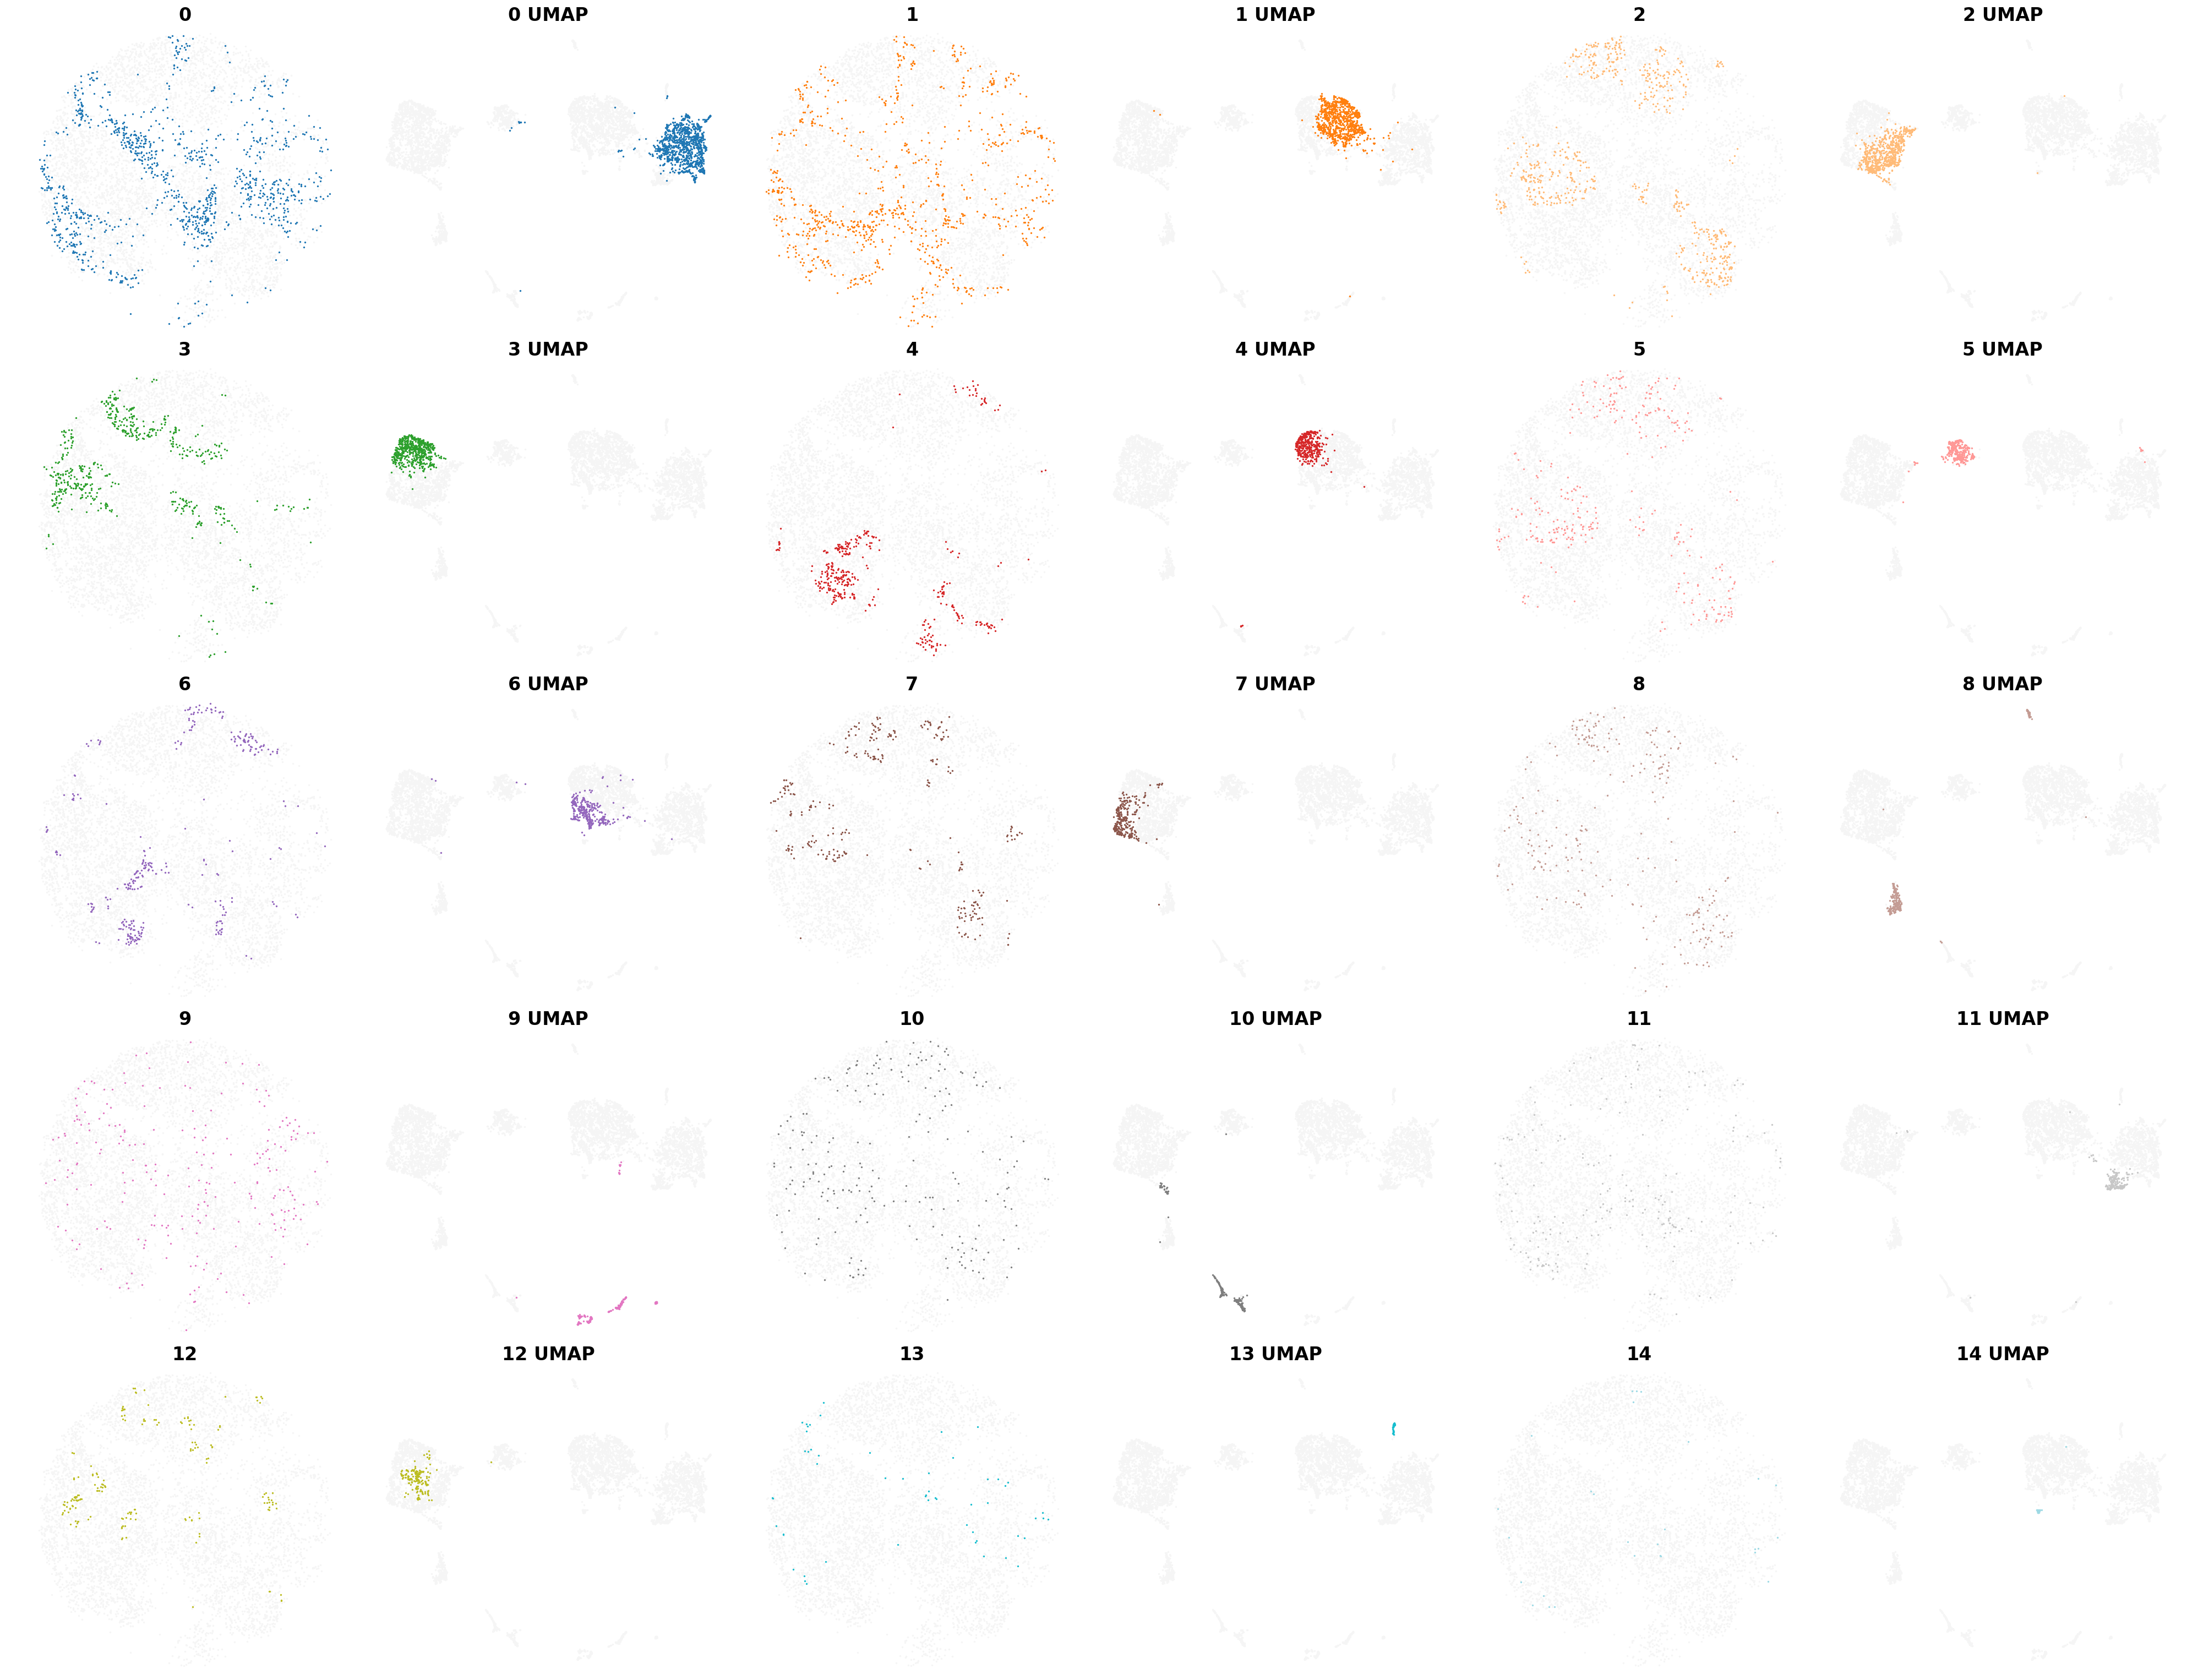

In [74]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = ('x', 'y', 'spatial'),
    max_num_labels  =  max_num_labels, 
    save_path = '/tmp',
    save_fig = False
)

In [77]:
results_df.iloc[0].adata.obs

cell_type cell_type_int            x            y  \
NAME                                                                            
AAACCCAAGCGCCTTG-1              T_CD4             5  1733.213235  1665.039824   
AAACCCAAGTGGACGT-1             plasma            12   519.377858  2220.266321   
AAACCCACAGAAGTGC-1  B_germinal_center             0  1064.296595  2158.266703   
AAACCCAGTCATTGCA-1            B_naive             2  1740.127314  3218.472808   
AAACCCATCATCGCAA-1           B_memory             1   930.600158  2892.947737   
...                               ...           ...          ...          ...   
TTTGTTGCAGGGACTA-1  B_germinal_center             0  1699.607471  1920.402412   
TTTGTTGCATTGTAGC-1             plasma            12   688.211974  2794.005768   
TTTGTTGGTACCACGC-1  B_germinal_center             0  1258.258885  2713.702000   
TTTGTTGGTCTGTCCT-1              T_CD4             5  1833.578543  2142.848257   
TTTGTTGTCATGCGGC-1              T_CD4             5  1056.736769  2472.335923   

                   banksy_cluster labels_scaled_gaussian_pc50_nc0.20_r1.50  
NAME                                                                        
AAACCCAAGCGCCTTG-1              1                                        0  
AAACCCAAGTGGACGT-1              5                                        8  
AAACCCACAGAAGTGC-1              3                                        2  
AAACCCAGTCATTGCA-1              1                                        1  
AAACCCATCATCGCAA-1              0                                        1  
...                           ...                                      ...  
TTTGTTGCAGGGACTA-1              3                                        3  
TTTGTTGCATTGTAGC-1              5                                        8  
TTTGTTGGTACCACGC-1              3                                        3  
TTTGTTGGTCTGTCCT-1              1                                        0  
TTTGTTGTCATGCGGC-1              1                                        0  

[5778 rows x 6 columns]

In [78]:
label = 'labels_scaled_gaussian_pc50_nc0.20_r1.50'

In [79]:
adata.obs['banksy_cluster'] = results_df.iloc[0].adata.obs.loc[adata.obs_names][label].copy()

In [59]:
adata.obs

cell_type cell_type_int            x            y  \
NAME                                                                            
AAACCCAAGCGCCTTG-1              T_CD4             5  1733.213235  1665.039824   
AAACCCAAGTGGACGT-1             plasma            12   519.377858  2220.266321   
AAACCCACAGAAGTGC-1  B_germinal_center             0  1064.296595  2158.266703   
AAACCCAGTCATTGCA-1            B_naive             2  1740.127314  3218.472808   
AAACCCATCATCGCAA-1           B_memory             1   930.600158  2892.947737   
...                               ...           ...          ...          ...   
TTTGTTGCAGGGACTA-1  B_germinal_center             0  1699.607471  1920.402412   
TTTGTTGCATTGTAGC-1             plasma            12   688.211974  2794.005768   
TTTGTTGGTACCACGC-1  B_germinal_center             0  1258.258885  2713.702000   
TTTGTTGGTCTGTCCT-1              T_CD4             5  1833.578543  2142.848257   
TTTGTTGTCATGCGGC-1              T_CD4             5  1056.736769  2472.335923   

                   banksy_cluster  
NAME                               
AAACCCAAGCGCCTTG-1              1  
AAACCCAAGTGGACGT-1              5  
AAACCCACAGAAGTGC-1              3  
AAACCCAGTCATTGCA-1              1  
AAACCCATCATCGCAA-1              0  
...                           ...  
TTTGTTGCAGGGACTA-1              3  
TTTGTTGCATTGTAGC-1              5  
TTTGTTGGTACCACGC-1              3  
TTTGTTGGTCTGTCCT-1              1  
TTTGTTGTCATGCGGC-1              1  

[5778 rows x 5 columns]

In [90]:
adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

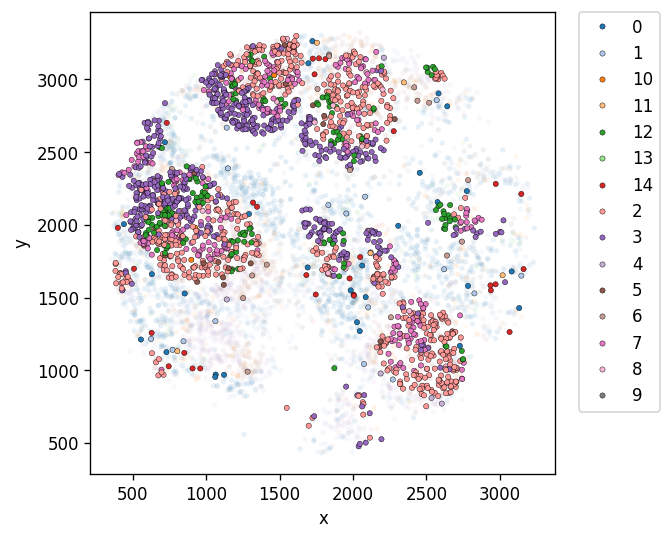

In [126]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 120
label = 'labels_scaled_gaussian_pc50_nc0.20_r0.90'
sns.scatterplot(
    data=adata.obs, 
    x='x', y='y', hue='banksy_cluster', s=10, 
    legend=False, palette='tab20', alpha=0.1)

sns.scatterplot(
    data=adata.obs[adata.obs.cell_type.isin(['B_germinal_center'])], 
    x='x', y='y', hue='banksy_cluster', s=10, linewidth=0.25, edgecolor='black',
    legend=True, palette='tab20')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [81]:
from scipy.stats import chi2_contingency
import numpy as np

In [84]:
# Calculate contingency table and chi-square test for correlation between categorical variables
contingency_table = pd.crosstab(adata.obs['cell_type'], adata.obs['banksy_cluster'])
chi2, p_value = chi2_contingency(contingency_table)[:2]

print("Chi-square test results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.2e}")

# Calculate Cramer's V correlation coefficient
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))

Chi-square test results:
Chi-square statistic: 37808.61
p-value: 0.00e+00


In [85]:
contingency_table

banksy_cluster         0    1   10   11   12  13  14    2    3    4    5    6  \
cell_type                                                                       
B_germinal_center     28   16    5    6  172   0  28  689  558    5   24   16   
B_memory               6  362    0    0    1   0   0    3    1   71    0   71   
B_naive               23  510    0    1    0   0   0    2    1  311    3  216   
FDC                    4    4  215    1    1   1   0    2    0    4    3    2   
NK                   148    2    0    5    0   0   0    1    0    1   13    0   
T_CD4                744    3    0    6    0   0   0    0    0    0   22    4   
T_CD8                 52    6    0  178    0   0   0    0    0    0    0    2   
T_double_neg          45    0    0    0    0   0   0    0    0    0    0    1   
T_follicular_helper   25    0    0    0    0   0   0    0    0    0  268    1   
mDC                    8    2    0    1    0   0   0    0    0    1    0    1   
myeloid                0    0    0    0    0   0   0    0    0    0    0    2   
pDC                    8    1    0    0    0  54   0    0    0    0    0    1   
plasma                 2    3    0    0    0   0   0    1    0    1    1    1   

banksy_cluster         7    8    9  
cell_type                           
B_germinal_center    280   21    0  
B_memory               1    0    0  
B_naive                0    0    0  
FDC                    0    2   16  
NK                     0    0    0  
T_CD4                  0    0    0  
T_CD8                  0    0    0  
T_double_neg           0    0    0  
T_follicular_helper    0    0    0  
mDC                    0    0  124  
myeloid                0    0  100  
pDC                    0    0    0  
plasma                 2  251    0

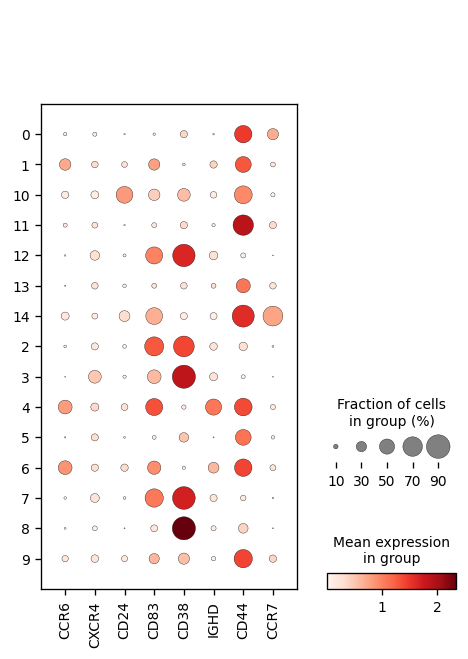

In [116]:
# Get B memory vs B naive cells
b_cells = adata.obs[adata.obs.cell_type.isin(['B_memory', 'B_naive'])]

# Plot marker gene expression
marker_genes = ['CCR6', 'CXCR4','CD24', 'CD83',
    'CD38', 'IGHD', 'CD44', 'CCR7']  # Key marker genes distinguishing memory vs naive B cells

sc.pl.dotplot(adata, marker_genes, groupby='banksy_cluster', dendrogram=False)


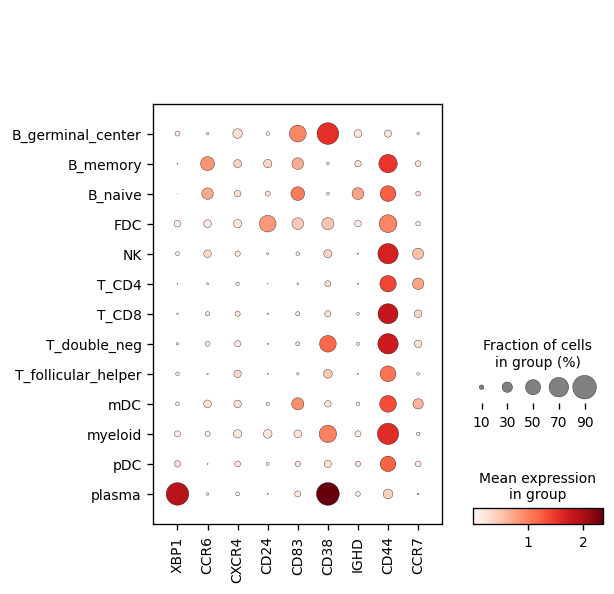

In [124]:
# Get B memory vs B naive cells
b_cells = adata.obs[adata.obs.cell_type.isin(['B_memory', 'B_naive'])]

# Plot marker gene expression
marker_genes = ['XBP1', 'CCR6', 'CXCR4','CD24', 'CD83',
    'CD38', 'IGHD', 'CD44', 'CCR7']  # Key marker genes distinguishing memory vs naive B cells

sc.pl.dotplot(adata, marker_genes, groupby='cell_type', dendrogram=False)


In [128]:
banksy2ct = {
    0: 'T_CD4',
    1: 'B_memory',
    2: 'GC Light Zone',
    3: 'GC Dark Zone',
    4: 'B_naive',
    5: 'T_follicular_helper',
    6: 'B_naive',
    7: 'GC Intermediate Zone',
    8: 'plasma',
    9: 'mDC/myeloid',
    10: 'FDC',
    11: 'T_CD8',
    12: 'GC Intermediate Zone',
    13: 'pDC',
    14: 'GC Light Zone', 
}

In [134]:
adata.obs['banksy_celltypes'] = adata.obs['banksy_cluster'].astype(int).map(banksy2ct)
adata.obs['banksy_celltypes']  = adata.obs['banksy_celltypes'].astype('category')

In [141]:
adata.obs['banksy_celltypes'].unique()

['T_CD4', 'plasma', 'GC Light Zone', 'B_memory', 'GC Intermediate Zone', ..., 'FDC', 'B_naive', 'T_CD8', 'mDC/myeloid', 'pDC']
Length: 12
Categories (12, object): ['B_memory', 'B_naive', 'FDC', 'GC Dark Zone', ..., 'T_follicular_helper', 'mDC/myeloid', 'pDC', 'plasma']

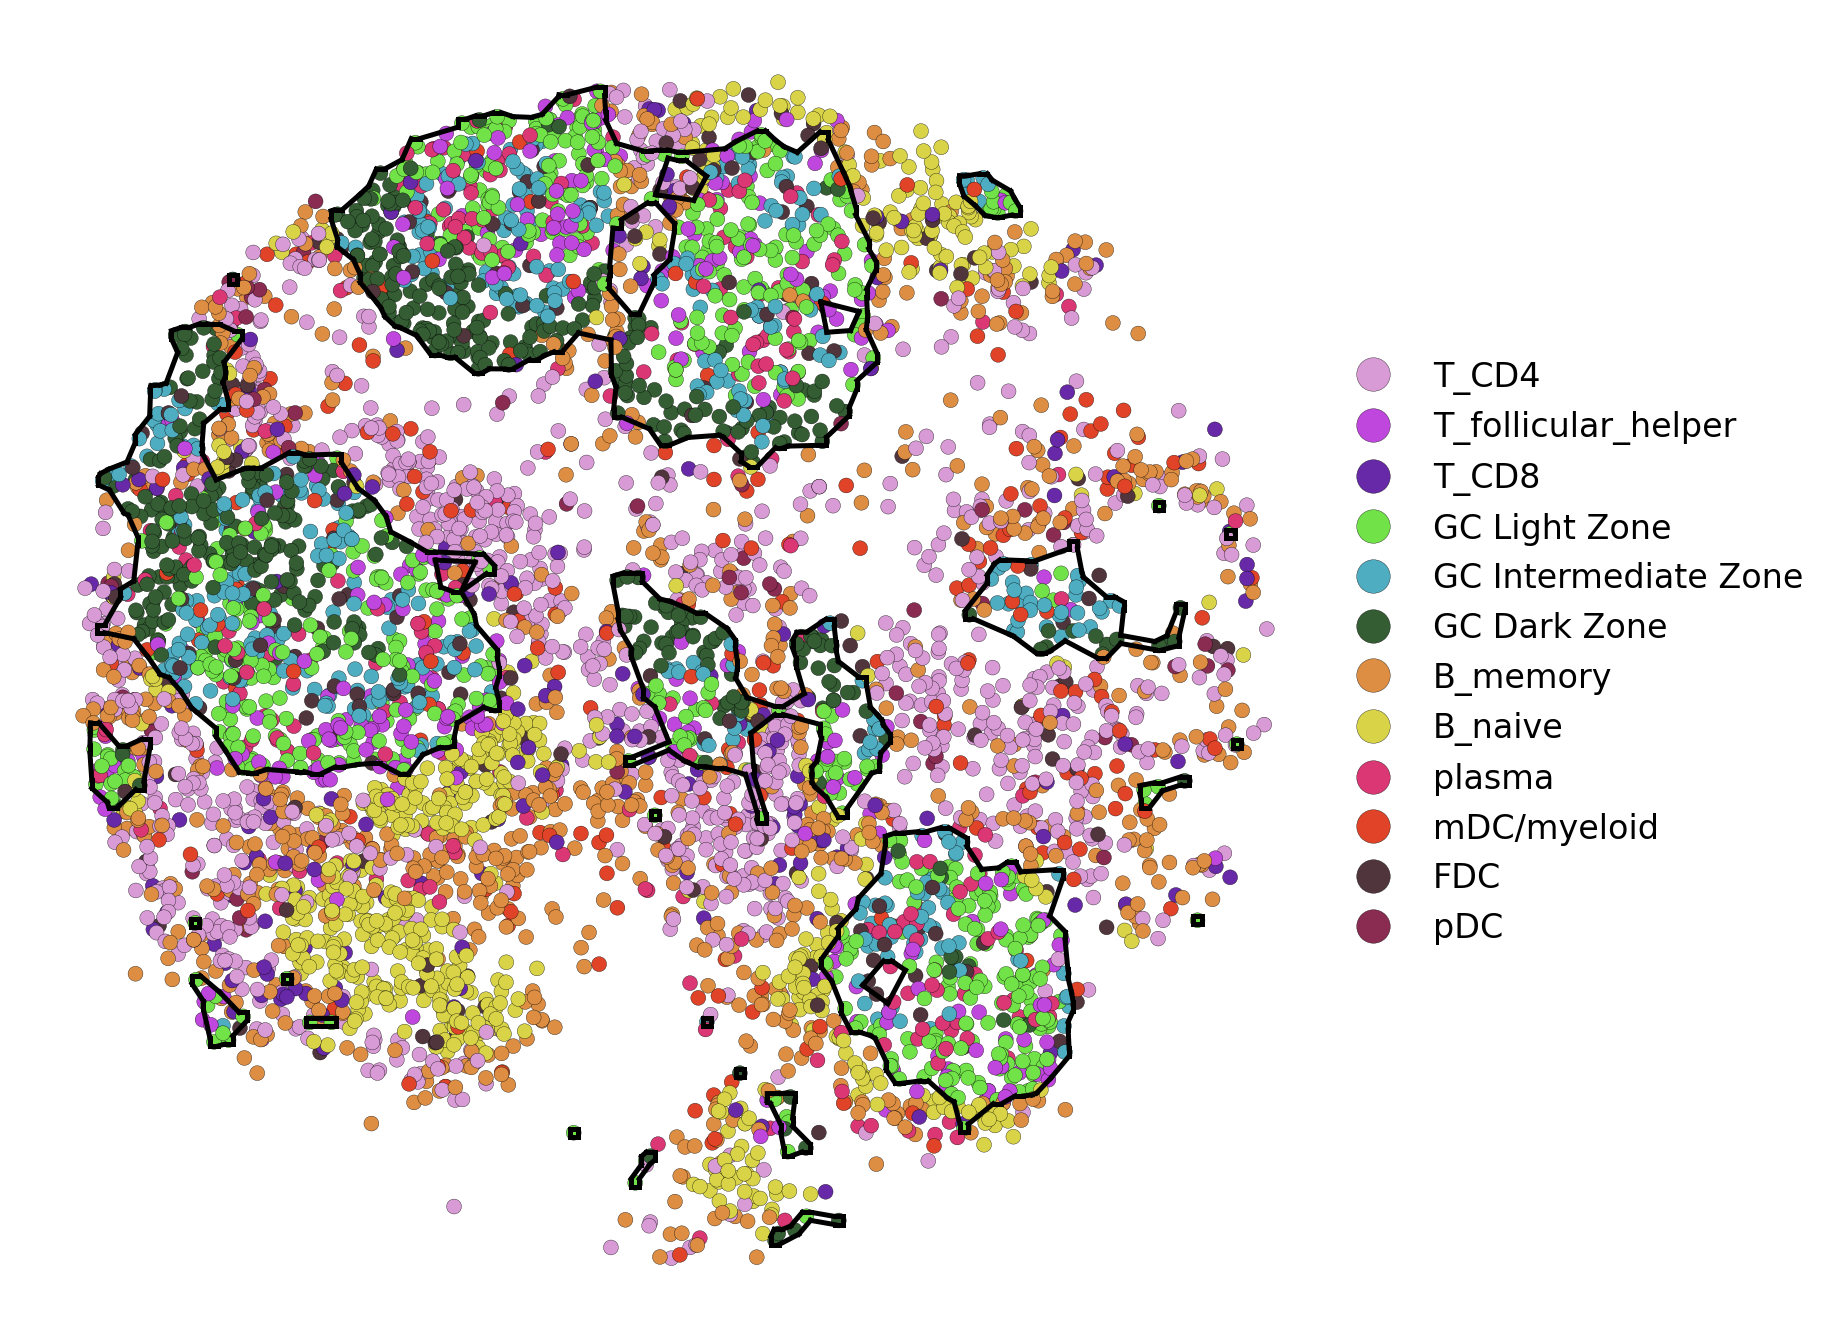

In [216]:
plt.rcParams['figure.figsize'] = (9.25, 9)
plt.rcParams['figure.dpi'] = 120
label = 'labels_scaled_gaussian_pc50_nc0.20_r0.90'

color_dict = {
    'T_CD4': "#d89bd5",
    'T_follicular_helper': "#c047dd", 
    'T_CD8': "#6729a7",
    'GC Light Zone': "#71e248",
    'GC Intermediate Zone': "#4fadc1",
    'GC Dark Zone': "#345d33",
    'B_memory': "#dd8e43",
    'B_naive': "#d9d447", 
    'plasma': "#db3774",
    'mDC/myeloid': "#e04327",
    'FDC': "#50363c",
    'pDC': "#8a2b52"
}
f, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=120)



points = np.asarray(
    adata[adata.obs['banksy_celltypes'].str.contains('GC')].obsm['spatial'])
delta = 10
points = np.vstack(
    (points +[-delta,delta], points +[-delta,-delta], points +[delta,delta], points +[delta,-delta]))

edges = alpha_shape(points, alpha=50, only_outer=True)

for ii, jj in edges:
    ax.plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=1.5)
    
g = sns.scatterplot(
    data=adata.obs, ax=ax,
    x='x', y='y', hue='banksy_celltypes', s=20,
    legend=True, palette=color_dict, alpha=1,
    edgecolor='black', linewidth=0.1, 
    # style='banksy_celltypes'
)


handles, labels = g.get_legend_handles_labels()
label_handle_map = dict(zip(labels, handles))
ordered_handles = [label_handle_map[key] for key in color_dict.keys()]
plt.legend(handles=ordered_handles, labels=color_dict.keys(), 
          bbox_to_anchor=(1, 0.75), loc='upper left',
          borderaxespad=0., frameon=False, fontsize=10, markerscale=2.25)

    
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.show()

In [279]:
adata.obs[['banksy_celltypes']].to_csv('/tmp/banksy_celltypes.csv')

In [232]:
sc.pp.neighbors(adata, use_rep='X')

In [256]:
sc.tl.umap(adata, min_dist=0.5, spread=1)

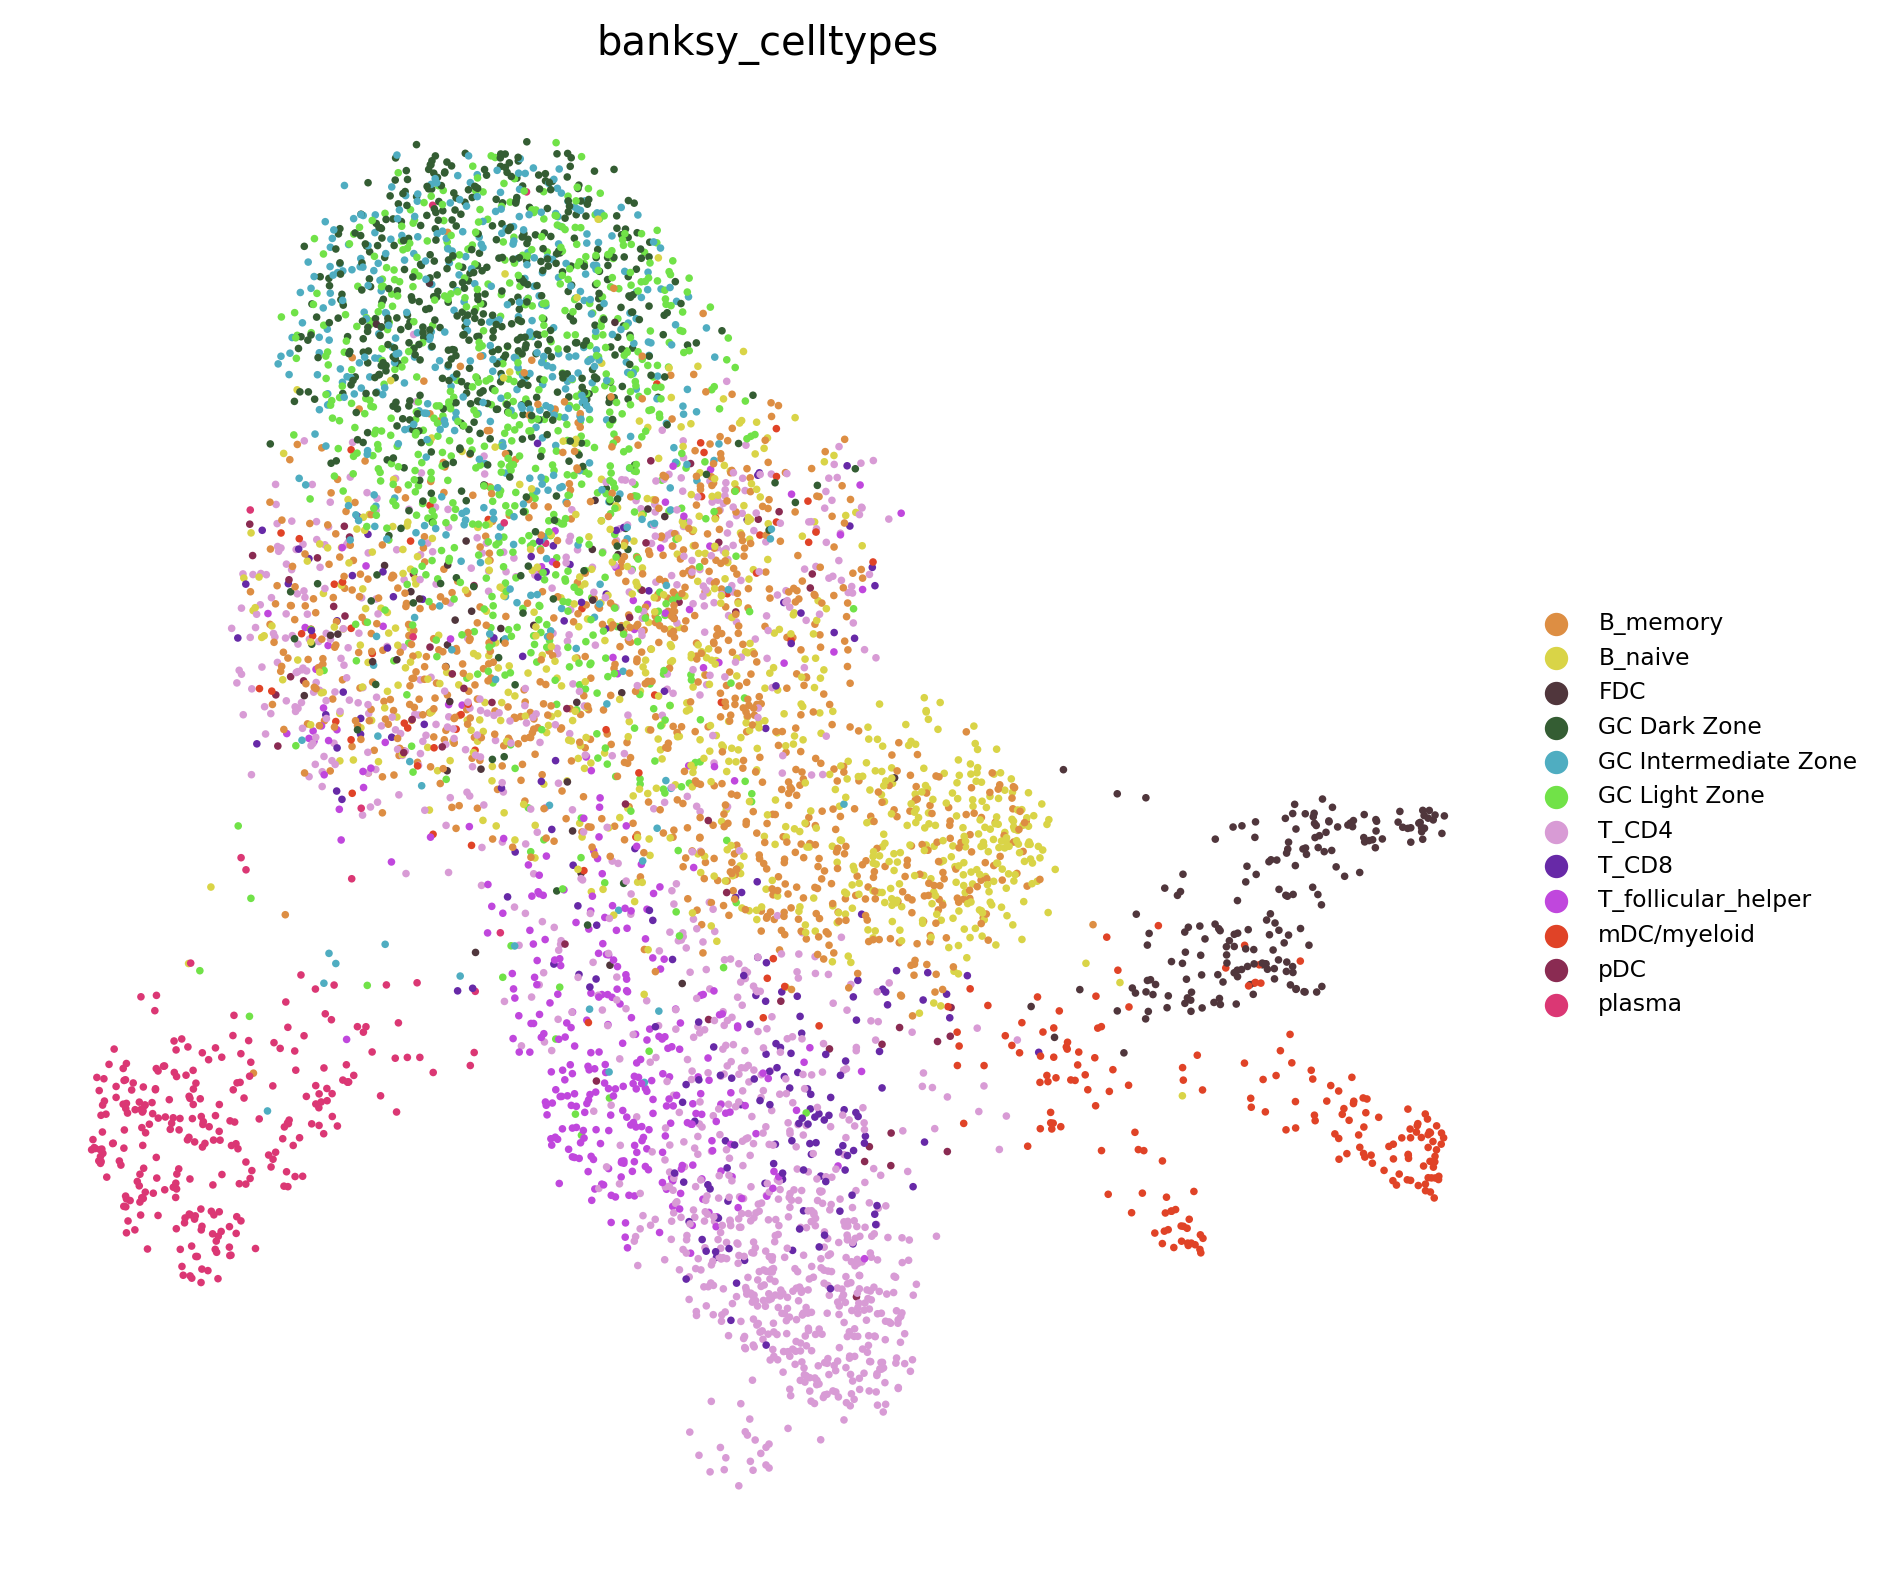

In [276]:
plt.rcParams['figure.figsize'] = (8, 8)
ax = sc.pl.umap(adata, color='banksy_celltypes', 
    legend_fontsize=7, palette=color_dict, frameon=False,
    show=False)